In [16]:
!pip install abc_analysis

1.1 & 1.2 Segmentation


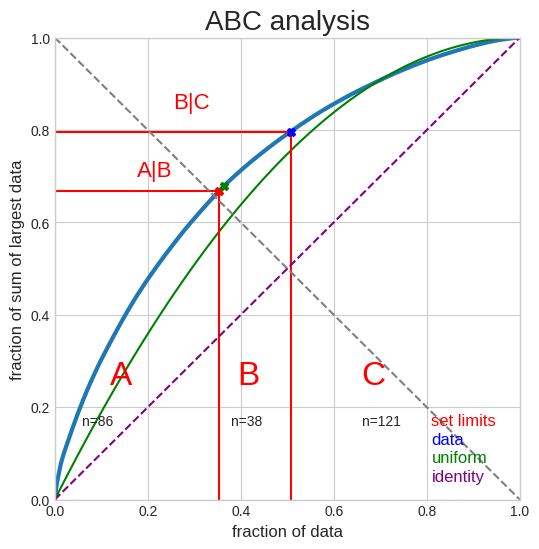

Volume segments distribution:
Seg_Vol
C    121
A     86
B     38
Name: count, dtype: int64


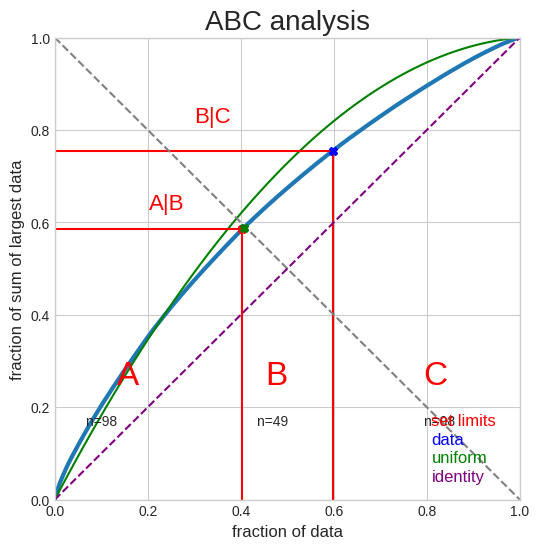

Variability segments distribution:
Seg_Var
C    98
A    98
B    49
Name: count, dtype: int64
1.3 - 1.5 Complex Features Calculation
Calculating features for each time series
Segments calculated. Sample:


,store_location_rk,product_rk,Seg_Vol,Seg_Var,Seg_Seas,Seg_Trend,Seg_Inter
0,309,40369,A,C,0,0,0
1,309,40370,A,C,0,0,0
2,309,40372,A,C,0,0,0
3,309,40373,A,C,0,0,0
4,309,46272,A,C,0,0,0


2.1 Naive Forecast
Dataset for evaluation ready. Rows: 33899
2.2 WAPE Calculation per Cell
WAPE calculated.
2.3 Ranking
Top 5 Easiest Segments:


,Seg_Vol,Seg_Var,Seg_Seas,Seg_Trend,Seg_Inter,AbsError,demand,product_rk,WAPE,FI_Rank
0,A,C,0,0,1,1351.881160,2653.069725,102,0.509554,1
1,A,C,0,1,0,2471.194446,4127.811111,255,0.598669,2
2,A,C,1,0,0,26022.158589,40962.716619,1907,0.635264,3
3,A,C,1,1,0,10490.016569,15859.176518,753,0.661448,4
4,B,C,1,1,0,1256.540984,1862.114758,153,0.674792,5


Top 5 Hardest Segments:


,Seg_Vol,Seg_Var,Seg_Seas,Seg_Trend,Seg_Inter,AbsError,demand,product_rk,WAPE,FI_Rank
25,A,A,0,0,0,2743.209762,2692.671253,106,1.018769,26
26,B,A,0,0,0,641.000000,598.000000,49,1.071906,27
27,B,A,1,0,0,22103.943816,20022.303797,1836,1.103966,28
28,C,A,1,0,0,14246.030618,12437.454182,2387,1.145414,29
29,C,A,0,0,0,557.000000,421.594512,49,1.321175,30


In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.stats import linregress
from abc_analysis import abc_analysis
import warnings

warnings.filterwarnings('ignore')

try:
    train = pd.read_csv('train.csv')

    train['period_start_dt'] = pd.to_datetime(train['period_start_dt'])
    train = train.sort_values(['store_location_rk', 'product_rk', 'period_start_dt'])

except FileNotFoundError:

    dates = pd.date_range(start='2019-01-01', periods=50, freq='W-MON')
    train = pd.DataFrame({
        'store_location_rk': [1]*50 + [2]*50,
        'product_rk': [101]*50 + [102]*50,
        'period_start_dt': list(dates) + list(dates),
        'demand': np.random.randint(10, 100, 100).astype(float)
    })


id_cols = ['store_location_rk', 'product_rk']

print("1.1 & 1.2 Segmentation")

volume = (
    train
    .groupby(id_cols)['demand']
    .mean()
    .reset_index(name='mean_demand')
)

abc_vol = abc_analysis(volume['mean_demand'].fillna(0).values, True)
a_idx = abc_vol['Aind']
b_idx = abc_vol['Bind']
c_idx = abc_vol['Cind']

volume['Seg_Vol'] = 'C'
volume.loc[a_idx, 'Seg_Vol'] = 'A'
volume.loc[b_idx, 'Seg_Vol'] = 'B'

df_segments = volume[id_cols + ['Seg_Vol']].copy()

print("Volume segments distribution:")
print(volume['Seg_Vol'].value_counts())

stats = (
    train
    .groupby(id_cols)['demand']
    .agg(mean_demand='mean', std_demand='std')
    .reset_index()
)

stats['cv'] = stats['std_demand'] / stats['mean_demand'].replace(0, 1)
stats['cv'] = stats['cv'].fillna(0)

abc_var = abc_analysis(stats['cv'].values, True)
a_idx_var = abc_var['Aind']
b_idx_var = abc_var['Bind']
c_idx_var = abc_var['Cind']

stats['Seg_Var'] = 'C'
stats.loc[a_idx_var, 'Seg_Var'] = 'A'
stats.loc[b_idx_var, 'Seg_Var'] = 'B'

print("Variability segments distribution:")
print(stats['Seg_Var'].value_counts())

df_segments = df_segments.merge(stats[id_cols + ['Seg_Var']], on=id_cols, how='inner')

print("1.3 - 1.5 Complex Features Calculation")

def get_ts_array(df, p, s):
    return df[(df.product_rk == p) & (df.store_location_rk == s)]['demand'].values

def find_seasonality(ts):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]
    if len(ts) < 3: return 1
    acf = np.correlate(ts - ts.mean(), ts - ts.mean(), 'full')[-len(ts):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    if len(peaks) == 0: return 1
    return int(peaks[acf[peaks].argmax()])

def get_seasonality_flag(ts):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]
    if len(ts) < 5: return 0
    seasonality = find_seasonality(ts)
    if len(ts) <= seasonality + 10: return 0
    acf = np.correlate(ts - ts.mean(), ts - ts.mean(), 'full')[-len(ts):]
    if acf[0] == 0: return 0
    acf_norm = acf / acf[0]
    return int(acf_norm[seasonality] > 0.25)

def get_trend_flag(ts):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]
    if len(ts) < 5: return 0
    x = np.arange(len(ts))
    if np.std(ts) == 0: return 0
    try:
        res = linregress(x, ts)
        return int(res.pvalue <= 0.05)
    except:
        return 0

def is_intermittent(ts):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]
    if len(ts) < 3: return 0
    intervals = []
    cur = 0
    for val in ts:
        if val == 0:
            if cur > 0: intervals.append(cur)
            cur = 0
        else:
            cur += 1
    if cur > 0: intervals.append(cur)
    if len(intervals) == 0: return 0
    return int(np.median(intervals) < 2)

print("Calculating features for each time series")

complex_feats = []
grouped = train.groupby(id_cols)['demand']

for name, group in grouped:
    ts = group.values
    complex_feats.append({
        'store_location_rk': name[0],
        'product_rk': name[1],
        'Seg_Seas': get_seasonality_flag(ts),
        'Seg_Trend': get_trend_flag(ts),
        'Seg_Inter': is_intermittent(ts)
    })

df_complex = pd.DataFrame(complex_feats)

df_segments_final = df_segments.merge(df_complex, on=id_cols, how='inner')
print("Segments calculated. Sample:")
display(df_segments_final.head())

print("2.1 Naive Forecast")

df_backtest = train.copy()
df_backtest['naive_forecast'] = df_backtest.groupby(id_cols)['demand'].shift(1)

df_backtest.dropna(subset=['naive_forecast', 'demand'], inplace=True)

full_df = df_backtest.merge(df_segments_final, on=id_cols, how='inner')

print(f"Dataset for evaluation ready. Rows: {len(full_df)}")

print("2.2 WAPE Calculation per Cell")

full_df['AbsError'] = abs(full_df['demand'] - full_df['naive_forecast'])

seg_cols = ['Seg_Vol', 'Seg_Var', 'Seg_Seas', 'Seg_Trend', 'Seg_Inter']

fi_cells = full_df.groupby(seg_cols).agg({
    'AbsError': 'sum',
    'demand': 'sum',
    'product_rk': 'count'
}).reset_index()

fi_cells['WAPE'] = fi_cells['AbsError'] / (fi_cells['demand'] + 1e-10)

print("WAPE calculated.")

print("2.3 Ranking")

fi_cells = fi_cells.sort_values(by='WAPE').reset_index(drop=True)

fi_cells['FI_Rank'] = fi_cells.index + 1

print("Top 5 Easiest Segments:")
display(fi_cells.head())

print("Top 5 Hardest Segments:")
display(fi_cells.tail())

fi_cells['Label'] = fi_cells.apply(
    lambda x: f"Vol:{x['Seg_Vol']} Var:{x['Seg_Var']} Seas:{x['Seg_Seas']} T:{x['Seg_Trend']} I:{x['Seg_Inter']}",
    axis=1
)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=fi_cells['FI_Rank'],
    y=fi_cells['WAPE'],
    mode='lines+markers',
    name='Benchmark WAPE',
    text=fi_cells['Label'],
    line=dict(color='green', width=2)
))

fig.update_layout(
    title='Forecastability Index Benchmark (Ordered 5-dim Cells)',
    xaxis_title='Rank (1 = Most Forecastable)',
    yaxis_title='WAPE (Naive Forecast)',
    template='plotly_white'
)

fig.show()